# Epic 8
Als een keyuser wil ik graag een lijst van accounts (bedrijven) kunnen opmaken die het meest waarschijnlijk zijn om hun lidmaatschap volgend jaar niet te hernieuwen

Om dit te kunnen uitvoeren, gaan we eerst inzicht in de data omtrent lidmaatschappen verwerven. Het is vooral belangrijk te achterhalen om welke redenen accounts in het verleden hun lidmaatschap hebben opgezegd.

## 1. Data inladen

In [1]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import optparse
import nltk
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st

#### Create connection to DWH


In [2]:
SERVER_NAME="127.0.0.1,1438"
SERVER_NAME_REMOTE="localhost"
DB_USER="sa"
DB_PASSWORD="Dep2Groep2-VIC"
DWH_NAME="Voka_DWH"

def connect_db(local=True):
    if local:
        URL_LOCAL = f'mssql+pyodbc://{SERVER_NAME}/{DWH_NAME}?trusted_connection=yes&driver=ODBC+Driver+17 for SQL Server'
        engine = create_engine(URL_LOCAL)
        conn = engine.connect()
        return conn
    else:
        URL = f'mssql+pymssql://{DB_USER}:{DB_PASSWORD}@{SERVER_NAME_REMOTE}:1438/{DWH_NAME}'
        engine = create_engine(URL)
        conn = engine.connect()
        return conn

In [3]:
conn = connect_db(local=False)

Create dataframe with all the data from the DWH

In [4]:
def create_query(table_name, columns, condition=None):

    query = f"SELECT "

    for i, column in enumerate(columns):
        if i == 0:
            query += f"[{column}]"
        else:
            query += f", [{column}]"
    
    query += f" FROM [{DWH_NAME}].[dbo].[{table_name}]"
    
    if condition:
        query += f" WHERE {condition}"

    return query


#### Merge Account en Lidmaatschap

In [5]:
#ACCOUNT DATA
#needed Account columns
account_col = ['accountID', 'plaats', 'isVokaEntiteit', 'accountStatus', 'ondernemingstype', 'ondernemingsaard', 'activiteitNaam']

#condition
account_condition = "provincie = 'Oost-Vlaanderen'"

#create query
account_query = create_query('DimAccount', account_col, account_condition)
df_account = pd.read_sql(account_query, conn)
df_account['plaats'] = df_account['plaats'].str.replace(r'\([a-z.-]+\)', '', regex=True).str.replace('  ', ' ')


df_account.shape


(50170, 7)

In [6]:
#LIDMAATSCHAP DATA
#needed Lidmaatschap columns
lidmaatschap_col = ['lidmaatschapID', 'accountID', 'redenAangroei', 'redenVerloop', 'startDatum', 'opzegDatum']

#create query
lidmaatschap_query = create_query('DimLidmaatschap', lidmaatschap_col)
df_lidmaatschap = pd.read_sql(lidmaatschap_query, conn)

df_lidmaatschap.shape

(6612, 6)

In [7]:
#Inschrijving Data
#needed Inschrijving columns
inschrijving_col = ['contactID', 'campagneID', 'inschrijvingsDatumID', 'facturatieBedrag']

#create query
inschrijving_query = create_query('FactInschrijving', inschrijving_col)
df_inschrijving = pd.read_sql(inschrijving_query, conn)

df_inschrijving.shape

(78790, 4)

#### Merge Lidmaatschap en Account

In [8]:
df_account_lid = df_account.merge(df_lidmaatschap, on='accountID', how='inner')
df_account_lid.shape

(6612, 12)

#### Merge Inschrijving en Contact

In [9]:
#needed contact col
contact_col = ['contactID', 'accountID']

#create query
contact_query = create_query('DimContact', contact_col)
df_contact = pd.read_sql(contact_query, conn)

df_contact.shape

(194192, 2)

In [10]:
df_inschrijving = df_inschrijving.merge(df_contact, on='contactID', how='left')
df_inschrijving.shape

(78790, 5)

#### Merge Inschrijving en Datum

In [11]:
#needed datum col
datum_col = ['dateID', 'fullDate']

#create query
datum_query = create_query('DimDate', datum_col)
df_datum = pd.read_sql(datum_query, conn)

df_datum.shape

(100806, 2)

In [12]:
df_inschrijving = df_inschrijving.merge(df_datum, left_on='inschrijvingsDatumID', right_on='dateID', how='left')


In [13]:
df_inschrijving.drop(columns=['dateID', 'inschrijvingsDatumID'], inplace=True)

In [14]:
df_inschrijving.head()

,contactID,campagneID,facturatieBedrag,accountID,fullDate
0,0017416A-2C6E-E111-B43A-00505680000A,82D778E0-1EC3-E811-80F5-001DD8B72B62,3000,18C73253-C368-E111-B43A-00505680000A,2019-01-21
1,0017416A-2C6E-E111-B43A-00505680000A,82D778E0-1EC3-E811-80F5-001DD8B72B62,3000,18C73253-C368-E111-B43A-00505680000A,2019-01-21
2,0017416A-2C6E-E111-B43A-00505680000A,82D778E0-1EC3-E811-80F5-001DD8B72B62,3000,18C73253-C368-E111-B43A-00505680000A,2019-01-21
3,0017416A-2C6E-E111-B43A-00505680000A,82D778E0-1EC3-E811-80F5-001DD8B72B62,3000,18C73253-C368-E111-B43A-00505680000A,2019-01-21
4,0017416A-2C6E-E111-B43A-00505680000A,82D778E0-1EC3-E811-80F5-001DD8B72B62,3000,18C73253-C368-E111-B43A-00505680000A,2019-01-21


In [15]:
#drop contactID from inschrijving
df_inschrijving.drop('contactID', axis=1, inplace=True)
df_inschrijving.shape

(78790, 4)

In [16]:
#inladen fin data
fin_col = ['accountID', 'toegevoegdeWaarde', 'boekjaar']

#create query
fin_query = create_query('DimFinanciëleDataAccount', fin_col)
df_fin = pd.read_sql(fin_query, conn)

df_fin.shape

(317954, 3)

#### Inladen Campagne 

In [17]:
#needed campagne col
campagne_col = ['campagneID', 'campagneNaam', 'campagneType']

#create query
campagne_query = create_query('DimCampagne', campagne_col)
df_campagne = pd.read_sql(campagne_query, conn)

df_campagne.shape

(4101, 3)

We hebben nu de volgende dataframes:
- df_account_lid = account + lidmaatschap info
- df_inschrijving = inschrijvingen per account
- df_financiële_data = financiële data per account
- df_campagne = de verschillende campagnes waarvoor een account kan inschrijven

## 2. Data analyseren

In [18]:
df_account_lid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6612 entries, 0 to 6611
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   accountID         6612 non-null   object
 1   plaats            6612 non-null   object
 2   isVokaEntiteit    6612 non-null   int64 
 3   accountStatus     6612 non-null   int64 
 4   ondernemingstype  6612 non-null   object
 5   ondernemingsaard  6612 non-null   object
 6   activiteitNaam    2448 non-null   object
 7   lidmaatschapID    6612 non-null   object
 8   redenAangroei     6612 non-null   object
 9   redenVerloop      6612 non-null   object
 10  startDatum        6612 non-null   object
 11  opzegDatum        6612 non-null   object
dtypes: int64(2), object(10)
memory usage: 620.0+ KB


In [19]:
df_account_lid.head()

,accountID,plaats,isVokaEntiteit,accountStatus,ondernemingstype,ondernemingsaard,activiteitNaam,lidmaatschapID,redenAangroei,redenVerloop,startDatum,opzegDatum
0,00002DAC-0A69-E111-B43A-00505680000A,BEVERE,0,1,Bedrijf,Diensten,Overige industrie & diensten,F10DF4A4-186F-E111-B43A-00505680000A,unknown,unknown,2011-12-07,2013-12-31
1,00025050-8D55-EB11-8117-001DD8B72B61,Melle,0,1,Familiebedrijf,Diensten,None,EB02B961-EFC1-EB11-8123-001DD8B72B62,Lead van een collega nalv contact of deelname,unknown,2021-05-20,2026-01-01
2,0012D444-0A69-E111-B43A-00505680000A,GERAARDSBERGEN,0,1,Bedrijf,Diensten,None,DFECE67E-146F-E111-B43A-00505680000A,unknown,Geen gebruik,2012-03-02,2016-03-28
3,0014BCC0-075B-EB11-811A-001DD8B72B62,MEILEGEM,0,1,Bedrijf,Diensten,None,42A999FB-6F69-ED11-9561-6045BD8952CE,Actieve werving: koude prospectie,unknown,2022-11-18,2026-01-01
4,0016CAE8-BD68-E111-B43A-00505680000A,GENTBRUGGE,0,1,Bedrijf,Productie & Diensten,Overige industrie & diensten,36CF5725-FA6E-E111-B43A-00505680000A,unknown,unknown,2010-12-17,2026-01-01


We gaan nu kijken naar de accounts waarvoor de accountStatus = 0. Dit zijn accounts die hun lidmaatschap hebben opgezegd. We willen nu achterhalen waarom ze dit hebben gedaan.

De meeste info die we hier voorlopig uit kunnen halen is voorlopig bij de reden 'Geen gebruik'. 'Unknown' is namelijk niet bruikbaar en 'Stopzetting' is te vaag. We gaan dus kijken naar de accounts waarvoor de reden 'Geen gebruik' is. (En we verwijderen de accounts waarvoor de reden 'Unknown' is => we maken nieuwe dataframe)

In [20]:
print(df_account_lid['opzegDatum'].unique())

[datetime.date(2013, 12, 31) datetime.date(2026, 1, 1)
 datetime.date(2016, 3, 28) ... datetime.date(2016, 3, 17)
 datetime.date(2012, 10, 25) datetime.date(2014, 4, 22)]


In [21]:
#opzegdatum omzetten naar string
df_account_lid['opzegDatum'] = df_account_lid['opzegDatum'].astype(str)
#we splitsen de dataframes in accounts waarvoor de opzegtdatum = 1950-01-01 en accounts waarvoor de opzegdatum != 1950-01-01
df_account_ACTIEF = df_account_lid[df_account_lid['opzegDatum'] == '2026-01-01']
df_account_INACTIEF = df_account_lid[df_account_lid['opzegDatum'] != '2026-01-01']

df_account_INACTIEF.shape


(4060, 12)

In [22]:
# #we verwijderen de rijen waarvoor redenVerloop = "unkown"
# df_account_INACTIEF = df_account_INACTIEF[df_account_INACTIEF['redenVerloop'] != 'unknown']
# df_account_INACTIEF.shape

In [23]:
#nagaan voor accounts met accountStatus = 0, wat redenVerloop is + sinds wanneer
df_account_INACTIEF['redenVerloop'].value_counts()


redenVerloop
unknown                      1841
Geen gebruik                 1007
Stopzetting                   409
Overzetting lidmaatschap      312
Wanbetaler                    139
Geen meerwaarde                90
Ontevreden/klacht              84
Prijs                          82
Faillissement                  75
Overname                       17
FinanciÃ«le moeilijkheden       4
Name: count, dtype: int64

In [24]:
df_account_ACTIEF.head(10)


,accountID,plaats,isVokaEntiteit,accountStatus,ondernemingstype,ondernemingsaard,activiteitNaam,lidmaatschapID,redenAangroei,redenVerloop,startDatum,opzegDatum
1,00025050-8D55-EB11-8117-001DD8B72B61,Melle,0,1,Familiebedrijf,Diensten,None,EB02B961-EFC1-EB11-8123-001DD8B72B62,Lead van een collega nalv contact of deelname,unknown,2021-05-20,2026-01-01
3,0014BCC0-075B-EB11-811A-001DD8B72B62,MEILEGEM,0,1,Bedrijf,Diensten,None,42A999FB-6F69-ED11-9561-6045BD8952CE,Actieve werving: koude prospectie,unknown,2022-11-18,2026-01-01
4,0016CAE8-BD68-E111-B43A-00505680000A,GENTBRUGGE,0,1,Bedrijf,Productie & Diensten,Overige industrie & diensten,36CF5725-FA6E-E111-B43A-00505680000A,unknown,unknown,2010-12-17,2026-01-01
5,002304C8-C268-E111-B43A-00505680000A,BUGGENHOUT,0,1,Familiebedrijf,Productie,None,2ACEEBEE-126F-E111-B43A-00505680000A,unknown,unknown,2007-01-01,2026-01-01
6,002C0FBC-C268-E111-B43A-00505680000A,Hamme (O.-Vl.),0,1,Familiebedrijf,Productie & Diensten,Ijzer en staal,A6713FE6-FB6E-E111-B43A-00505680000A,unknown,unknown,2007-01-01,2026-01-01
8,003EB9D8-0A29-E811-80F0-001DD8B72B61,Ledeberg,0,1,Bedrijf,Diensten,None,CF9E5EAE-41C6-E811-80F5-001DD8B72B62,Actieve werving: koude prospectie,unknown,2018-10-01,2026-01-01
9,004CB1A1-4C92-ED11-AAD1-6045BD895D85,Gent,0,1,Bedrijf,Diensten,None,C6A46201-4E92-ED11-AAD1-6045BD895D85,unknown,unknown,2023-01-09,2026-01-01
10,004E24A6-0A69-E111-B43A-00505680000A,DENDERMONDE,0,1,Bedrijf,Diensten,Telecom & IT,CF25E5EF-E76E-E111-B43A-00505680000A,unknown,unknown,2012-01-17,2026-01-01
11,0059AC0E-2D17-EA11-8109-001DD8B72B62,SINT-MARTENS-LATEM,0,1,Bedrijf,Diensten,None,9F9DF7C6-2D17-EA11-8109-001DD8B72B62,Actieve werving: koude prospectie,unknown,2019-11-30,2026-01-01
15,006A3322-F65B-E711-80E8-001DD8B72B61,DENDERMONDE,0,1,Bedrijf,Productie,None,B338E25F-F65B-E711-80E8-001DD8B72B61,unknown,Overzetting lidmaatschap,2007-01-01,2026-01-01


Nu willen we voor een bepaald accountID uit de dataframe df_account_INACTIEF de aantal inschrijvingen tellen (per campagne) per jaar. We willen dit doen voor telkens het jaar VOOR het jaar van de opzegDatum.

In [25]:
#jaar voor opzegDatum per acountID bepalen
df_account_INACTIEF['jaar'] = df_account_INACTIEF['opzegDatum'].str[:4] 
df_account_INACTIEF['boekjaar'] = df_account_INACTIEF['jaar'].astype(int) - 1
df_account_INACTIEF.drop('jaar', axis=1, inplace=True)

df_account_INACTIEF.head()

C:\Users\emmad\AppData\Local\Temp\ipykernel_27884\3102564824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_account_INACTIEF['jaar'] = df_account_INACTIEF['opzegDatum'].str[:4]
C:\Users\emmad\AppData\Local\Temp\ipykernel_27884\3102564824.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_account_INACTIEF['boekjaar'] = df_account_INACTIEF['jaar'].astype(int) - 1
C:\Users\emmad\AppData\Local\Temp\ipykernel_27884\3102564824.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,accountID,plaats,isVokaEntiteit,accountStatus,ondernemingstype,ondernemingsaard,activiteitNaam,lidmaatschapID,redenAangroei,redenVerloop,startDatum,opzegDatum,boekjaar
0,00002DAC-0A69-E111-B43A-00505680000A,BEVERE,0,1,Bedrijf,Diensten,Overige industrie & diensten,F10DF4A4-186F-E111-B43A-00505680000A,unknown,unknown,2011-12-07,2013-12-31,2012
2,0012D444-0A69-E111-B43A-00505680000A,GERAARDSBERGEN,0,1,Bedrijf,Diensten,None,DFECE67E-146F-E111-B43A-00505680000A,unknown,Geen gebruik,2012-03-02,2016-03-28,2015
7,003B965B-C268-E111-B43A-00505680000A,GENT,0,1,Bedrijf,Diensten,Telecom & IT,D7D751D6-2D6F-E111-B43A-00505680000A,Actieve werving: koude prospectie,Geen gebruik,2013-07-04,2017-01-19,2016
12,005C6F7F-A268-E111-B43A-00505680000A,SINT-MARTENS-LATEM,0,1,Bedrijf,Diensten,None,4F8AA590-BA47-EC11-8C62-6045BD8D2834,Lead van een collega nalv contact of deelname,Prijs,2021-11-16,2021-12-30,2020
13,0062F706-0969-E111-B43A-00505680000A,DEINZE,0,1,Bedrijf,Productie,None,45C679CB-086F-E111-B43A-00505680000A,unknown,Geen gebruik,2007-01-02,2013-07-01,2012


Nu hebben we dus de dataframe van accounts die hun lidmaatschap hebben opgezegd bij Voka + het jaar VOOR de opzegdatum van deze accounts. Nu gaan we voor dit jaar gaan tellen hoeveel inschrijvingen er zijn per accountID per campagne.

In [26]:
#voorbereiding inschrijving
df_inschrijving['fullDate'] = df_inschrijving['fullDate'].astype(str)
df_inschrijving['jaar'] = df_inschrijving['fullDate'].str[:4]
df_inschrijving['jaar'] = df_inschrijving['jaar'].astype(int)
df_inschrijving.head()


,campagneID,facturatieBedrag,accountID,fullDate,jaar
0,82D778E0-1EC3-E811-80F5-001DD8B72B62,3000,18C73253-C368-E111-B43A-00505680000A,2019-01-21,2019
1,82D778E0-1EC3-E811-80F5-001DD8B72B62,3000,18C73253-C368-E111-B43A-00505680000A,2019-01-21,2019
2,82D778E0-1EC3-E811-80F5-001DD8B72B62,3000,18C73253-C368-E111-B43A-00505680000A,2019-01-21,2019
3,82D778E0-1EC3-E811-80F5-001DD8B72B62,3000,18C73253-C368-E111-B43A-00505680000A,2019-01-21,2019
4,82D778E0-1EC3-E811-80F5-001DD8B72B62,3000,18C73253-C368-E111-B43A-00505680000A,2019-01-21,2019


In [27]:
#hoeveel inschrijvingen per accountID van df_account_INACTIEF in het voorbije jaar (zie kolom voorbije_jaar in df) per campagneID
for i, row in df_account_INACTIEF.iterrows():
    accountID = row['accountID']
    boekjaar = row['boekjaar']
    df_account_INACTIEF.loc[i, 'aantal_inschrijvingen'] = df_inschrijving[(df_inschrijving['accountID'] == accountID) & (df_inschrijving['jaar'] == boekjaar)]['accountID'].count()

C:\Users\emmad\AppData\Local\Temp\ipykernel_27884\4220383235.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_account_INACTIEF.loc[i, 'aantal_inschrijvingen'] = df_inschrijving[(df_inschrijving['accountID'] == accountID) & (df_inschrijving['jaar'] == boekjaar)]['accountID'].count()


In [28]:
df_account_INACTIEF.head()

,accountID,plaats,isVokaEntiteit,accountStatus,ondernemingstype,ondernemingsaard,activiteitNaam,lidmaatschapID,redenAangroei,redenVerloop,startDatum,opzegDatum,boekjaar,aantal_inschrijvingen
0,00002DAC-0A69-E111-B43A-00505680000A,BEVERE,0,1,Bedrijf,Diensten,Overige industrie & diensten,F10DF4A4-186F-E111-B43A-00505680000A,unknown,unknown,2011-12-07,2013-12-31,2012,0.0
2,0012D444-0A69-E111-B43A-00505680000A,GERAARDSBERGEN,0,1,Bedrijf,Diensten,None,DFECE67E-146F-E111-B43A-00505680000A,unknown,Geen gebruik,2012-03-02,2016-03-28,2015,0.0
7,003B965B-C268-E111-B43A-00505680000A,GENT,0,1,Bedrijf,Diensten,Telecom & IT,D7D751D6-2D6F-E111-B43A-00505680000A,Actieve werving: koude prospectie,Geen gebruik,2013-07-04,2017-01-19,2016,0.0
12,005C6F7F-A268-E111-B43A-00505680000A,SINT-MARTENS-LATEM,0,1,Bedrijf,Diensten,None,4F8AA590-BA47-EC11-8C62-6045BD8D2834,Lead van een collega nalv contact of deelname,Prijs,2021-11-16,2021-12-30,2020,0.0
13,0062F706-0969-E111-B43A-00505680000A,DEINZE,0,1,Bedrijf,Productie,None,45C679CB-086F-E111-B43A-00505680000A,unknown,Geen gebruik,2007-01-02,2013-07-01,2012,0.0


In [29]:
# voor hoeveel accounts is aantal inschrijvingen = 0
df_account_INACTIEF[df_account_INACTIEF['aantal_inschrijvingen'] == 0]['accountID'].count()

3671

In [30]:
df_account_ACTIEF['boekjaar'] = 2022
df_account_ACTIEF.shape

C:\Users\emmad\AppData\Local\Temp\ipykernel_27884\3440652843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_account_ACTIEF['boekjaar'] = 2022


(2552, 13)

In [31]:
for i, row in df_account_ACTIEF.iterrows():
    accountID = row['accountID']
    boekjaar = row['boekjaar']
    df_account_ACTIEF.loc[i, 'aantal_inschrijvingen'] = df_inschrijving[(df_inschrijving['accountID'] == accountID) & (df_inschrijving['jaar'] == boekjaar)]['accountID'].count()

C:\Users\emmad\AppData\Local\Temp\ipykernel_27884\1773367148.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_account_ACTIEF.loc[i, 'aantal_inschrijvingen'] = df_inschrijving[(df_inschrijving['accountID'] == accountID) & (df_inschrijving['jaar'] == boekjaar)]['accountID'].count()


In [32]:
df_account_ACTIEF.head()

,accountID,plaats,isVokaEntiteit,accountStatus,ondernemingstype,ondernemingsaard,activiteitNaam,lidmaatschapID,redenAangroei,redenVerloop,startDatum,opzegDatum,boekjaar,aantal_inschrijvingen
1,00025050-8D55-EB11-8117-001DD8B72B61,Melle,0,1,Familiebedrijf,Diensten,None,EB02B961-EFC1-EB11-8123-001DD8B72B62,Lead van een collega nalv contact of deelname,unknown,2021-05-20,2026-01-01,2022,0.0
3,0014BCC0-075B-EB11-811A-001DD8B72B62,MEILEGEM,0,1,Bedrijf,Diensten,None,42A999FB-6F69-ED11-9561-6045BD8952CE,Actieve werving: koude prospectie,unknown,2022-11-18,2026-01-01,2022,5.0
4,0016CAE8-BD68-E111-B43A-00505680000A,GENTBRUGGE,0,1,Bedrijf,Productie & Diensten,Overige industrie & diensten,36CF5725-FA6E-E111-B43A-00505680000A,unknown,unknown,2010-12-17,2026-01-01,2022,0.0
5,002304C8-C268-E111-B43A-00505680000A,BUGGENHOUT,0,1,Familiebedrijf,Productie,None,2ACEEBEE-126F-E111-B43A-00505680000A,unknown,unknown,2007-01-01,2026-01-01,2022,0.0
6,002C0FBC-C268-E111-B43A-00505680000A,Hamme (O.-Vl.),0,1,Familiebedrijf,Productie & Diensten,Ijzer en staal,A6713FE6-FB6E-E111-B43A-00505680000A,unknown,unknown,2007-01-01,2026-01-01,2022,16.0


In [33]:
# voor hoeveel accounts is aantal inschrijvingen = 0
df_account_ACTIEF[df_account_ACTIEF['aantal_inschrijvingen'] == 0]['accountID'].count()

1251

In [34]:
#we voegen lidmaatschap_actief kolom toe aan df_account_ACTIEF waar allemaal = 1
df_account_ACTIEF['lidmaatschap_actief'] = 1
df_account_INACTIEF['lidmaatschap_actief'] = 0

C:\Users\emmad\AppData\Local\Temp\ipykernel_27884\3507007459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_account_ACTIEF['lidmaatschap_actief'] = 1
C:\Users\emmad\AppData\Local\Temp\ipykernel_27884\3507007459.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_account_INACTIEF['lidmaatschap_actief'] = 0


In [35]:
df_account_INACTIEF.shape

(4060, 15)

In [36]:
#we voegen de df account_ACTIEF toe aan df_account_INACTIEF en noemen het df
df = pd.concat([df_account_INACTIEF, df_account_ACTIEF], axis=0)
df.drop('accountStatus', axis=1, inplace=True)
df.drop('ondernemingsaard', axis=1, inplace=True)
df.shape

(6612, 13)

In [37]:
df.head()

,accountID,plaats,isVokaEntiteit,ondernemingstype,activiteitNaam,lidmaatschapID,redenAangroei,redenVerloop,startDatum,opzegDatum,boekjaar,aantal_inschrijvingen,lidmaatschap_actief
0,00002DAC-0A69-E111-B43A-00505680000A,BEVERE,0,Bedrijf,Overige industrie & diensten,F10DF4A4-186F-E111-B43A-00505680000A,unknown,unknown,2011-12-07,2013-12-31,2012,0.0,0
2,0012D444-0A69-E111-B43A-00505680000A,GERAARDSBERGEN,0,Bedrijf,None,DFECE67E-146F-E111-B43A-00505680000A,unknown,Geen gebruik,2012-03-02,2016-03-28,2015,0.0,0
7,003B965B-C268-E111-B43A-00505680000A,GENT,0,Bedrijf,Telecom & IT,D7D751D6-2D6F-E111-B43A-00505680000A,Actieve werving: koude prospectie,Geen gebruik,2013-07-04,2017-01-19,2016,0.0,0
12,005C6F7F-A268-E111-B43A-00505680000A,SINT-MARTENS-LATEM,0,Bedrijf,None,4F8AA590-BA47-EC11-8C62-6045BD8D2834,Lead van een collega nalv contact of deelname,Prijs,2021-11-16,2021-12-30,2020,0.0,0
13,0062F706-0969-E111-B43A-00505680000A,DEINZE,0,Bedrijf,None,45C679CB-086F-E111-B43A-00505680000A,unknown,Geen gebruik,2007-01-02,2013-07-01,2012,0.0,0


In [38]:
df = df.merge(df_fin, on=['accountID', 'boekjaar'], how='left')

In [39]:
# welke verschillende mogelijkheden binnen 'ondernemingsaard' zijn er? geef elke mogelijkheid in lijst
df['activiteitNaam'].nunique()

66

## 3. Data Cleaning

Nu gaan we voor deze gemergede dataframe nog onehotencoding toepassen 

In [40]:
#one hot encoding voor df_account_INACTIEF 
#USING sklearn OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

redenAangroei_cat = ['unknown', 'Actieve werving: koude prospectie',
       'Lead van een collega nalv contact of deelname',
       'Overzetting lidmaatschap', 'Spontane aanvraag via de website',
       'Actieve werving: tip van een collega',
       'Actieve werving: marketingcampagne',
       'Lead van een andere Voka entiteit',
       'Leden maken leden: Lead van een Voka lid',
       'Spontane aanvraag via mail']
redenVerloop_cat = ['unknown', 'Geen gebruik', 'Prijs', 'Overname', 'Stopzetting',
       'Wanbetaler', 'Ontevreden/klacht', 'Overzetting lidmaatschap',
       'Geen meerwaarde', 'Faillissement', 'FinanciÃ«le moeilijkheden']


In [41]:
# Ondernemingstype
ondernemingstype_categories = [
 {'categorie': 'unknown', 'binary': None},
 {'categorie': 'Beroepsorganisatie', 'binary': None},
 {'categorie': 'Vakbonden', 'binary': None},
 {'categorie': 'Eenmanszaak', 'binary': None},
 {'categorie': 'Multinational', 'binary': None},
 {'categorie': 'Sociale organisatie', 'binary': None},
 {'categorie': 'Werkgeversorganisaties', 'binary': None},
 {'categorie': 'Pers/Media', 'binary': None},
 {'categorie': 'Overheid', 'binary': None},
 {'categorie': 'Onderwijs', 'binary': None},
 {'categorie': 'Social Profit', 'binary': None},
 {'categorie': 'Vrije beroepen', 'binary': None},
 {'categorie': 'Familiebedrijf', 'binary': None},
 {'categorie': 'Bedrijf', 'binary': None}
]

for i, categorie in enumerate(ondernemingstype_categories):
  categorie['binary'] = str(bin(i)[2:].zfill(4))

category_to_binary = {categorie['categorie']: categorie['binary'] for categorie in ondernemingstype_categories}
df['ondernemingstype'] = df['ondernemingstype'].map(category_to_binary)

for i in range(1, 5):
    df[f'ondernemingstype_{i}'] = df['ondernemingstype'].apply(lambda x: int(str(x)[i-1]))

In [42]:
df['activiteitNaam'] = df['activiteitNaam'].apply(lambda x: 'unknown' if x == 'Luchthavengerelateerd' else x)
    
    # Primaire activiteit
activiteitNaam_categories = [
      {'categorie': 'unknown', 'binary': None},
      {'categorie': 'Farmacie', 'binary': None},
      {'categorie': 'Diamant, edelstenen, juwelen', 'binary': None},
      {'categorie': 'Havengerelateerd', 'binary': None},
      {'categorie': 'Media', 'binary': None},
      {'categorie': 'Overheid', 'binary': None},
      {'categorie': 'Verenigingen en maatschappelijke organisaties', 'binary': None},
      {'categorie': 'Onderwijs', 'binary': None},
      {'categorie': 'Milieu', 'binary': None},
      {'categorie': 'Vrije beroepen', 'binary': None},
      {'categorie': 'Agrarische & bio-industrie', 'binary': None},
      {'categorie': 'Hout- en meubelindustrie', 'binary': None},
      {'categorie': 'Accountancy & boekhouding', 'binary': None},
      {'categorie': 'Vastgoed', 'binary': None},
      {'categorie': 'Verzekering', 'binary': None},
      {'categorie': 'Financiële diensten', 'binary': None},
      {'categorie': 'Grafische industrie en diensten', 'binary': None},
      {'categorie': 'Automobiel- en Tweewielerindustrie', 'binary': None},
      {'categorie': 'Textiel, kleding en confectie', 'binary': None},
      {'categorie': 'Horeca & toerisme', 'binary': None},
      {'categorie': 'Technologische industrie & diensten', 'binary': None},
      {'categorie': 'Zorg', 'binary': None},
      {'categorie': 'Detailhandel', 'binary': None},
      {'categorie': 'Groothandel', 'binary': None},
      {'categorie': 'Bouw', 'binary': None},
      {'categorie': 'Energie', 'binary': None},
      {'categorie': 'Consultancy', 'binary': None},
      {'categorie': 'Papier & karton', 'binary': None},
      {'categorie': 'Human capital', 'binary': None},
      {'categorie': 'Chemie, petrochemie', 'binary': None},
      {'categorie': 'Distributie, logistiek en transport', 'binary': None},
      {'categorie': 'Telecom & IT', 'binary': None},
      {'categorie': 'Ijzer en staal', 'binary': None},
      {'categorie': 'Voeding', 'binary': None},
      {'categorie': 'Overige industrie & diensten', 'binary': None}
    ]
    
df['activiteitNaam'] = df['activiteitNaam'].apply(lambda x: 'unknown' if x not in [categorie['categorie'] for categorie in activiteitNaam_categories] else x)

for i, categorie in enumerate(activiteitNaam_categories):
        categorie['binary'] = str(bin(i)[2:].zfill(6))

category_to_binary = {categorie['categorie']: categorie['binary'] for categorie in activiteitNaam_categories}
df['activiteitNaam'] = df['activiteitNaam'].map(category_to_binary)

for i in range(1, 7):
        df[f'activiteitNaam_{i}'] = df['activiteitNaam'].apply(lambda x: int(str(x)[i-1]))
    


In [43]:
activiteitNaam_categories

[{'categorie': 'unknown', 'binary': '000000'},
 {'categorie': 'Farmacie', 'binary': '000001'},
 {'categorie': 'Diamant, edelstenen, juwelen', 'binary': '000010'},
 {'categorie': 'Havengerelateerd', 'binary': '000011'},
 {'categorie': 'Media', 'binary': '000100'},
 {'categorie': 'Overheid', 'binary': '000101'},
 {'categorie': 'Verenigingen en maatschappelijke organisaties',
  'binary': '000110'},
 {'categorie': 'Onderwijs', 'binary': '000111'},
 {'categorie': 'Milieu', 'binary': '001000'},
 {'categorie': 'Vrije beroepen', 'binary': '001001'},
 {'categorie': 'Agrarische & bio-industrie', 'binary': '001010'},
 {'categorie': 'Hout- en meubelindustrie', 'binary': '001011'},
 {'categorie': 'Accountancy & boekhouding', 'binary': '001100'},
 {'categorie': 'Vastgoed', 'binary': '001101'},
 {'categorie': 'Verzekering', 'binary': '001110'},
 {'categorie': 'Financiële diensten', 'binary': '001111'},
 {'categorie': 'Grafische industrie en diensten', 'binary': '010000'},
 {'categorie': 'Automobiel- 

In [44]:
# activiteitNaam_encoder = OneHotEncoder(categories=[activiteitnaam_cat], sparse=False)
# ondernemingstype_encoder = OneHotEncoder(categories=[ondernemingstype_cat], sparse=False)
redenAangroei_encoder = OneHotEncoder(categories=[redenAangroei_cat], sparse=False)
redenVerloop_encoder = OneHotEncoder(categories=[redenVerloop_cat], sparse=False)

# activiteitNaam_1hot = activiteitNaam_encoder.fit_transform(df[['activiteitNaam']])
# ondernemingstype_1hot = ondernemingstype_encoder.fit_transform(df[['ondernemingstype']])
redenAangroei_1hot = redenAangroei_encoder.fit_transform(df[['redenAangroei']])
redenVerloop_1hot = redenVerloop_encoder.fit_transform(df[['redenVerloop']])

c:\Users\emmad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\emmad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [45]:
# # # Ondernemingstype
# ondernemingstype_categories = [
#  {'categorie': 'unknown', 'binary': None},
#  {'categorie': 'Beroepsorganisatie', 'binary': None},
#  {'categorie': 'Vakbonden', 'binary': None},
#  {'categorie': 'Eenmanszaak', 'binary': None},
#  {'categorie': 'Multinational', 'binary': None},
#  {'categorie': 'Sociale organisatie', 'binary': None},
#  {'categorie': 'Werkgeversorganisaties', 'binary': None},
#  {'categorie': 'Pers/Media', 'binary': None},
#  {'categorie': 'Overheid', 'binary': None},
#  {'categorie': 'Onderwijs', 'binary': None},
#  {'categorie': 'Social Profit', 'binary': None},
#  {'categorie': 'Vrije beroepen', 'binary': None},
#  {'categorie': 'Familiebedrijf', 'binary': None},
#  {'categorie': 'Bedrijf', 'binary': None}
# ]

# for i, categorie in enumerate(ondernemingstype_categories):
#   categorie['binary'] = str(bin(i)[2:].zfill(4))

# category_to_binary = {categorie['categorie']: categorie['binary'] for categorie in ondernemingstype_categories}
# df['ondernemingstype'] = df['ondernemingstype'].map(category_to_binary)

# for i in range(1, 5):
#     df[f'ondernemingstype_{i}'] = df['ondernemingstype'].apply(lambda x: int(str(x)[i-1]))

In [46]:
df = df.drop(['activiteitNaam', 'redenAangroei', 'redenVerloop', 'ondernemingstype' ], axis=1)

In [47]:
#fill na toegevoegdeWaarde df
df['toegevoegdeWaarde'].fillna(-1, inplace=True)

In [48]:
# df = df.join(pd.DataFrame(activiteitNaam_1hot), rsuffix='_activiteitNaam')
df = df.join(pd.DataFrame(redenAangroei_1hot), rsuffix='_redenAangroei')
df = df.join(pd.DataFrame(redenVerloop_1hot), rsuffix='_redenVerloop')

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6647 entries, 0 to 6646
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   accountID              6647 non-null   object 
 1   plaats                 6647 non-null   object 
 2   isVokaEntiteit         6647 non-null   int64  
 3   lidmaatschapID         6647 non-null   object 
 4   startDatum             6647 non-null   object 
 5   opzegDatum             6647 non-null   object 
 6   boekjaar               6647 non-null   int64  
 7   aantal_inschrijvingen  6647 non-null   float64
 8   lidmaatschap_actief    6647 non-null   int64  
 9   toegevoegdeWaarde      6647 non-null   object 
 10  ondernemingstype_1     6647 non-null   int64  
 11  ondernemingstype_2     6647 non-null   int64  
 12  ondernemingstype_3     6647 non-null   int64  
 13  ondernemingstype_4     6647 non-null   int64  
 14  activiteitNaam_1       6647 non-null   int64  
 15  acti

In [50]:
df.drop('lidmaatschapID', axis=1, inplace=True)
df.drop('plaats', axis=1, inplace=True)


In [51]:
#kopieer kolommen accountID, startDatum, opzegDatum naar nieuwe dataframe
df_hulp = df[['accountID', 'startDatum', 'opzegDatum']]

#drop deze uit vorige df
df.drop('accountID', axis=1, inplace=True)
df.drop('startDatum', axis=1, inplace=True)
df.drop('opzegDatum', axis=1, inplace=True)
df.drop('boekjaar', axis=1, inplace=True)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6647 entries, 0 to 6646
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   isVokaEntiteit         6647 non-null   int64  
 1   aantal_inschrijvingen  6647 non-null   float64
 2   lidmaatschap_actief    6647 non-null   int64  
 3   toegevoegdeWaarde      6647 non-null   object 
 4   ondernemingstype_1     6647 non-null   int64  
 5   ondernemingstype_2     6647 non-null   int64  
 6   ondernemingstype_3     6647 non-null   int64  
 7   ondernemingstype_4     6647 non-null   int64  
 8   activiteitNaam_1       6647 non-null   int64  
 9   activiteitNaam_2       6647 non-null   int64  
 10  activiteitNaam_3       6647 non-null   int64  
 11  activiteitNaam_4       6647 non-null   int64  
 12  activiteitNaam_5       6647 non-null   int64  
 13  activiteitNaam_6       6647 non-null   int64  
 14  0                      6647 non-null   float64
 15  1   

In [53]:
print(df['toegevoegdeWaarde'].unique())

['-1' '37261' '6.22433e+006' ... '2.77326e+007' '689150' '125591']


In [54]:
#alle floats uit df omzetten naar int

df['toegevoegdeWaarde']= df['toegevoegdeWaarde'].astype(float)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6647 entries, 0 to 6646
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   isVokaEntiteit         6647 non-null   int64  
 1   aantal_inschrijvingen  6647 non-null   float64
 2   lidmaatschap_actief    6647 non-null   int64  
 3   toegevoegdeWaarde      6647 non-null   float64
 4   ondernemingstype_1     6647 non-null   int64  
 5   ondernemingstype_2     6647 non-null   int64  
 6   ondernemingstype_3     6647 non-null   int64  
 7   ondernemingstype_4     6647 non-null   int64  
 8   activiteitNaam_1       6647 non-null   int64  
 9   activiteitNaam_2       6647 non-null   int64  
 10  activiteitNaam_3       6647 non-null   int64  
 11  activiteitNaam_4       6647 non-null   int64  
 12  activiteitNaam_5       6647 non-null   int64  
 13  activiteitNaam_6       6647 non-null   int64  
 14  0                      6647 non-null   float64
 15  1   

## 4. Model trainen

Nu gaan we voor deze situatie een model trainen die op basis van de aantal_inschrijvingen in het voorbije jaar gaat voorspellen of een account zijn lidmaatschap gaat opzeggen of niet. We gaan dit doen voor de accounts die hun lidmaatschap hebben opgezegd bij Voka.

In [56]:
#Nu gaan we voor deze situatie een model trainen die op basis van de aantal_inschrijvingen in het voorbije jaar gaat voorspellen of een account in het volgende jaar het lidmaatchap gaat opzeggen
#We gaan hiervoor een random forest model gebruiken
#We gaan eerst de data opsplitsen in een train en test set
#We gaan de data opsplitsen in een train en test set



In [57]:
#opsplitsen in X en y
X = df.drop('lidmaatschap_actief', axis=1)
y = df['lidmaatschap_actief']

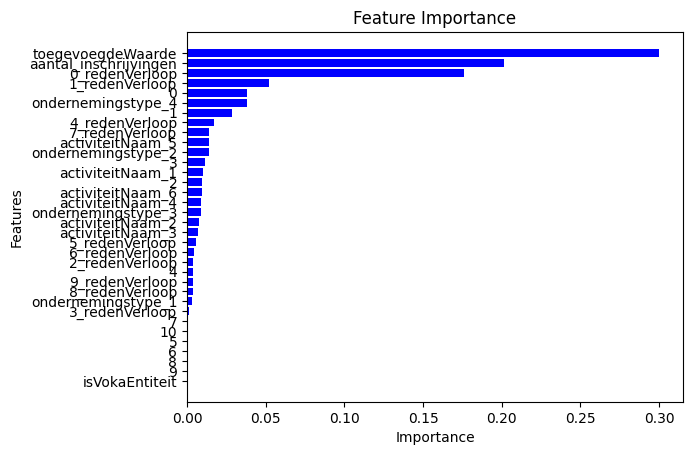

<Figure size 1500x1500 with 0 Axes>

(34, 1)

In [58]:
# Make sure its strings
X.columns = X.columns.astype(str)

# Checking feature importance
forest_clf = RandomForestClassifier(random_state=42, n_estimators=500, n_jobs=-1)
forest_clf.fit(X, y)  # Assuming y is a Pandas Series or a NumPy array

importances = forest_clf.feature_importances_
featureNames = X.columns

features = pd.DataFrame({'feature': featureNames, 'importance': importances})
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

plt.barh(features.index, features['importance'], color='b')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.figure(figsize=(15, 15))
plt.show()

features.shape


(13, 1)

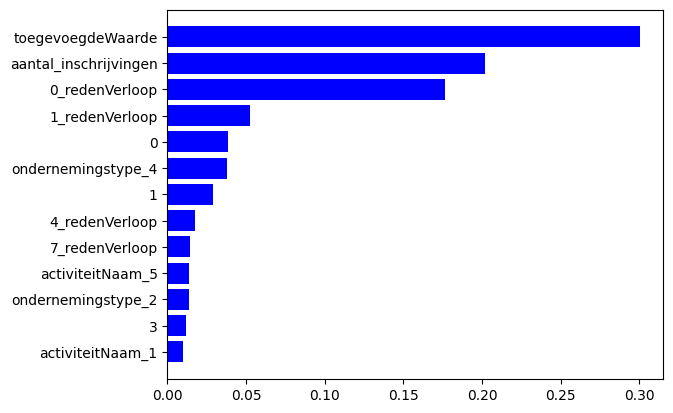

In [59]:
#we willen alleen de features betrekken met een importance van meer dan 0.01
features = features[features['importance'] > 0.01]

#we bekijken opnieuw de grafiek
plt.barh(features.index, features['importance'], color='b')

#hoeveel features zijn er overgebleven?
features.shape

In [60]:
#opslitsen in train en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((5317, 34), (1330, 34), (5317,), (1330,))

In [61]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [62]:
def models_gs(model):
    try:
        grid_search = GridSearchCV(model["model"], param_grid=model["param_grid"], cv=5, scoring="accuracy", return_train_score=True, n_jobs=-1)
        grid_search.fit(X_train, y_train)
    
        best_model = grid_search.best_estimator_
        return (best_model, grid_search.best_score_)
    
    except Exception as e:
        print(f"{model['name']} failed with error: {e}")

In [63]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier


In [64]:
non_ensemble_models_param_grid = [
   {
      "name":"linearsvc",
      "model": LinearSVC(random_state=42),
      "param_grid": {
         "C":[0.1, 0.5, 1, 2.5, 5, 10, 20, 50, 75, 100, 125, 150, 200, 250, 500, 1000],
         "penalty": ["l2"]
      }
   },
   {
      "name":"sgdclassifier",
      "model": SGDClassifier(random_state=42),
      "param_grid":{
         "alpha":[0.001, 0.01, 0.1, 0.5, 1],
         "penalty":["l2"],
         "max_iter": [1000],
         "loss": ["log_loss"]
      }
   },
   {
      "name":"logisticregression",
      "model": LogisticRegression(random_state=42, max_iter=1000),
      "param_grid":{
         "C":[0.1, 0.5, 1, 2.5, 5, 10, 20, 50, 75, 100, 125, 150, 200, 250, 500, 1000],
         "penalty":["l2"]
      }
   },
   {
      "name":"decisiontreeclassifier",
      "model": DecisionTreeClassifier(random_state=42),
      "param_grid":{
         "max_depth":[5, 10, 15, 20, 25, 30],
         "min_samples_split":[2, 5, 10, 15],
         "min_samples_leaf":[2, 5, 10, 15],
      }
   },
]

In [65]:
for model in non_ensemble_models_param_grid:
  print(f'Starting {model["name"]}...')
  gs = models_gs(model)
  print(gs)

Starting linearsvc...


c:\Users\emmad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\emmad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(LinearSVC(C=2.5, random_state=42), 0.778631020165654)
Starting sgdclassifier...
(SGDClassifier(alpha=0.001, loss='log_loss', random_state=42), 0.6276114203665325)
Starting logisticregression...
(LogisticRegression(C=0.1, max_iter=1000, random_state=42), 0.6257299528218476)
Starting decisiontreeclassifier...
(DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42), 0.8478504586961287)


In [66]:
best_models = [
  {
    'name': 'linearsvc',
    'model': LinearSVC(C=100, loss='hinge', random_state=42)
  },
  {
    'name': 'sgdclassifier',
    'model': SGDClassifier(alpha=0.001, loss='log_loss', random_state=42)
  },
  {
    'name': 'logisticregression',
    'model': LogisticRegression(C=0.1, max_iter=1000, random_state=42)
  },
  {
    'name': 'deciciontreeclassifier',
    'model': DecisionTreeClassifier(max_depth=25, min_samples_leaf=2, random_state=42)
  },
]

In [67]:
for model in best_models:
  cv_score = cross_val_score(model["model"], X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1)
  print(f'{model["name"]} - cross validation scores: {np.mean(cv_score)}')

linearsvc - cross validation scores: 0.784274008162457
sgdclassifier - cross validation scores: 0.6276114203665325
logisticregression - cross validation scores: 0.6257299528218476
deciciontreeclassifier - cross validation scores: 0.8155010645145317


In [68]:
rfc = {
      "name":"randomforestclassifier",
      "model": RandomForestClassifier(random_state=42, n_jobs=-1),
      "param_grid":{
         "n_estimators":[50, 75, 100, 125, 150, 175, 200],
         "min_samples_split":[2, 5, 10],
         "min_samples_leaf":[2, 5, 10],
      }
    }

In [69]:
print(f"Starting {rfc['name']}...")
gs = models_gs(rfc)
print(gs)

Starting randomforestclassifier...


(RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=42), 0.8580070236739543)


In [70]:
best_models.append({
  'name': 'randomforestclassifier',
  'model': RandomForestClassifier(min_samples_leaf=2, n_estimators=150, n_jobs=-1, random_state=42)
})

In [71]:
voting_clfs = [
    {
        "name": "votingclassifier",
        "diff": "hard",
        "model": VotingClassifier(estimators=[
            ('linsvc', best_models[0]['model']),
            ('sgd', best_models[1]['model']),
            ('lr', best_models[2]['model']),
            ('dt', best_models[3]['model']),
            ('rf', best_models[4]['model']),
        ], voting='hard', n_jobs=-1),
        "param_grid": {
            'weights': [
                [1, 1, 1, 1, 1],
                [1, 1, 1, 1, 2], 
                [1, 1, 1, 2, 2], 
                [1, 1, 2, 2, 2], 
                [1, 2, 2, 2, 2],
                [2, 2, 2, 2, 2]
            ]
        }
    },
    {
        "name": "votingclassifier",
        "diff": "soft",
        "model": VotingClassifier(estimators=[
            ('sgd', best_models[1]['model']),
            ('lr', best_models[2]['model']),
            ('dt', best_models[3]['model']),
            ('rf', best_models[4]['model']),
        ], voting='soft', n_jobs=-1),
        "param_grid": {
            'weights': [
                [1, 1, 1, 1], 
                [1, 1, 1, 2], 
                [1, 1, 2, 2], 
                [1, 2, 2, 2], 
                [2, 2, 2, 2]
            ]
        }
    }
]

In [72]:
for model in voting_clfs:
    print(f"Starting {model['diff']}-voting model...")
    gs = models_gs({
        "name": model["name"],
        "model": model["model"],
        "param_grid": model["param_grid"]
    })
    print(gs)

Starting hard-voting model...


(VotingClassifier(estimators=[('linsvc',
                              LinearSVC(C=100, loss='hinge', random_state=42)),
                             ('sgd',
                              SGDClassifier(alpha=0.001, loss='log_loss',
                                            random_state=42)),
                             ('lr',
                              LogisticRegression(C=0.1, max_iter=1000,
                                                 random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=25,
                                                     min_samples_leaf=2,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(min_samples_leaf=2,
                                                     n_estimators=150,
                                                     n_jobs=-1,
                                      

In [73]:
best_models.append({
  "name": "votingclassifier_hard",
  "model": VotingClassifier(estimators=[('linsvc',
                              LinearSVC(C=100, loss='hinge', random_state=42)),
                             ('sgd',
                              SGDClassifier(alpha=0.001, loss='log_loss',
                                            random_state=42)),
                             ('lr',
                              LogisticRegression(C=0.1, max_iter=1000,
                                                 random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=25,
                                                     min_samples_leaf=2,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(min_samples_leaf=2,
                                                     n_estimators=150,
                                                     n_jobs=-1,
                                                     random_state=42))],
                 n_jobs=-1, weights=[1, 1, 1, 2, 2])
})

best_models.append({
  "name": "votingclassifier_soft",
  "model": VotingClassifier(estimators=[('sgd',
                              SGDClassifier(alpha=0.001, loss='log_loss',
                                            random_state=42)),
                             ('lr',
                              LogisticRegression(C=0.1, max_iter=1000,
                                                 random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=25,
                                                     min_samples_leaf=2,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(min_samples_leaf=2,
                                                     n_estimators=150,
                                                     n_jobs=-1,
                                                     random_state=42))],
                 n_jobs=-1, voting='soft', weights=[1, 1, 2, 2])
})

In [74]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = {
    "name": 'BaggingClassifier',
    "model": BaggingClassifier(base_estimator=best_models[3]["model"], random_state=42, n_jobs=-1, oob_score=True),
    "param_grid": {
        "n_estimators": [10, 50, 100, 150],
        "bootstrap": [True],  # Set bootstrap to [True] for out-of-bag estimation
        "max_samples": [0.5, 0.75, 1.0],
    }
}


In [75]:
print(f"Starting {bagging_clf['name']}...")
gs = models_gs(bagging_clf)
print(gs)

Starting BaggingClassifier...


c:\Users\emmad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


(BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=25,
                                                        min_samples_leaf=2,
                                                        random_state=42),
                  max_samples=0.5, n_estimators=150, n_jobs=-1, oob_score=True,
                  random_state=42), 0.8548085288479902)


In [76]:
best_models.append({
  "name": "BaggingClassifier",
  "model": BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=25,
                                                        min_samples_leaf=2,
                                                        random_state=42),
                  n_estimators=150, n_jobs=-1, oob_score=True, random_state=42)
})

In [77]:
adaboost_clf = {
    "name": 'AdaBoostClassifier',
    "model": AdaBoostClassifier(random_state=42),
    "param_grid": {
        "base_estimator": [best_models[3]["model"]],
        "n_estimators": [10, 50, 100, 150],
        "learning_rate": [0.1, 0.5, 1.0, 2.0],
        "algorithm": ['SAMME.R']
    }
}

In [78]:
print(f"Starting {adaboost_clf['name']}...")
gs = models_gs(adaboost_clf)
print(gs)

Starting AdaBoostClassifier...


c:\Users\emmad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=25,
                                                         min_samples_leaf=2,
                                                         random_state=42),
                   learning_rate=0.1, n_estimators=150, random_state=42), 0.8369397152335212)


In [79]:
best_models.append({
  "name": "AdaBoostClassifier",
  "model": AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=25,
                                                         min_samples_leaf=2,
                                                         random_state=42),
                   learning_rate=0.5, n_estimators=100, random_state=42)
})

In [80]:
gradient_boosting_clf = {
    "name": 'GradientBoostingClassifier',
    "model": GradientBoostingClassifier(random_state=42),
    "param_grid": {
        "n_estimators": [10, 50, 100, 150],
        "learning_rate": [0.1, 0.5, 1.0, 2.0],
        "min_samples_split": [2, 5, 10],
    }
}

In [81]:
print(f"Starting {gradient_boosting_clf['name']}...")
gs = models_gs(gradient_boosting_clf)
print(gs)

Starting GradientBoostingClassifier...


(GradientBoostingClassifier(random_state=42), 0.8566898195630186)


In [82]:
best_models.append({
  "name": "GradientBoostingClassifier",
  "model": GradientBoostingClassifier(learning_rate=0.5, min_samples_split=10,
                           n_estimators=150, random_state=42)
})

In [83]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
estimators = [
    ('sgd', best_models[1]['model']),
    ('lr', best_models[2]['model']),
    ('dt', best_models[3]['model']),
    ('rf', best_models[4]['model']),
]

final_estimators = [
    ('sgd', SGDClassifier(random_state=42, loss='log_loss')),
    ('lr', LogisticRegression(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
]

stacking_clfs = [
    {
        "name": 'StackingClassifier',
        "diff": final_estimators[0][0],
        "model": StackingClassifier(estimators=estimators, final_estimator=final_estimators[0][1], n_jobs=-1),
        "param_grid": {}
    },
    {
        "name": 'StackingClassifier',
        "diff": final_estimators[1][0],
        "model": StackingClassifier(estimators=estimators, final_estimator=final_estimators[1][1], n_jobs=-1),
        "param_grid": {}
    },
    {
        "name": 'StackingClassifier',
        "diff": final_estimators[2][0],
        "model": StackingClassifier(estimators=estimators, final_estimator=final_estimators[2][1], n_jobs=-1),
        "param_grid": {}
    },
    {
        "name": 'StackingClassifier',
        "diff": final_estimators[3][0],
        "model": StackingClassifier(estimators=estimators, final_estimator=final_estimators[3][1], n_jobs=-1),
        "param_grid": {}
    }
]

In [84]:
for i in stacking_clfs:
    print(f"Starting {i['name']}_{i['diff']}...")
    gs = models_gs(i)
    print(gs)

Starting StackingClassifier_sgd...


(StackingClassifier(estimators=[('sgd',
                                SGDClassifier(alpha=0.001, loss='log_loss',
                                              random_state=42)),
                               ('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=25,
                                                       min_samples_leaf=2,
                                                       random_state=42)),
                               ('rf',
                                RandomForestClassifier(min_samples_leaf=2,
                                                       n_estimators=150,
                                                       n_jobs=-1,
                                                       random_state=42))],
                   final_estimator=SGDClassifier(loss='

In [85]:
best_models.append({
  "name": "StackingClassifier_sgd",
  "model": StackingClassifier(estimators=[('sgd',
                                SGDClassifier(alpha=0.001, loss='log_loss',
                                              random_state=42)),
                               ('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=25,
                                                       min_samples_leaf=2,
                                                       random_state=42)),
                               ('rf',
                                RandomForestClassifier(min_samples_leaf=2,
                                                       n_estimators=150,
                                                       n_jobs=-1,
                                                       random_state=42))],
                   final_estimator=SGDClassifier(loss='log_loss',
                                                 random_state=42),
                   n_jobs=-1)
})
best_models.append({
  "name": "StackingClassifier_lr",
  "model": StackingClassifier(estimators=[('sgd',
                                SGDClassifier(alpha=0.001, loss='log_loss',
                                              random_state=42)),
                               ('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=25,
                                                       min_samples_leaf=2,
                                                       random_state=42)),
                               ('rf',
                                RandomForestClassifier(min_samples_leaf=2,
                                                       n_estimators=150,
                                                       n_jobs=-1,
                                                       random_state=42))],
                   final_estimator=LogisticRegression(random_state=42),
                   n_jobs=-1)
})
best_models.append({
  "name": "StackingClassifier",
  "model": StackingClassifier(estimators=[('sgd',
                                SGDClassifier(alpha=0.001, loss='log_loss',
                                              random_state=42)),
                               ('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=25,
                                                       min_samples_leaf=2,
                                                       random_state=42)),
                               ('rf',
                                RandomForestClassifier(min_samples_leaf=2,
                                                       n_estimators=150,
                                                       n_jobs=-1,
                                                       random_state=42))],
                   final_estimator=DecisionTreeClassifier(random_state=42),
                   n_jobs=-1)
})
best_models.append({
  "name": "StackingClassifier_rf",
  "model": StackingClassifier(estimators=[('sgd',
                                SGDClassifier(alpha=0.001, loss='log_loss',
                                              random_state=42)),
                               ('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=25,
                                                       min_samples_leaf=2,
                                                       random_state=42)),
                               ('rf',
                                RandomForestClassifier(min_samples_leaf=2,
                                                       n_estimators=150,
                                                       n_jobs=-1,
                                                       random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1)
})

In [86]:
# Train best models
for model in best_models:
    print(f"Training {model['name']}...")
    model['model'].fit(X_train, y_train)
    print(f"Training {model['name']} done!")

Training linearsvc...
Training linearsvc done!
Training sgdclassifier...


c:\Users\emmad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\emmad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training sgdclassifier done!
Training logisticregression...
Training logisticregression done!
Training deciciontreeclassifier...
Training deciciontreeclassifier done!
Training randomforestclassifier...
Training randomforestclassifier done!
Training votingclassifier_hard...
Training votingclassifier_hard done!
Training votingclassifier_soft...
Training votingclassifier_soft done!
Training BaggingClassifier...


c:\Users\emmad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training BaggingClassifier done!
Training AdaBoostClassifier...


c:\Users\emmad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training AdaBoostClassifier done!
Training GradientBoostingClassifier...
Training GradientBoostingClassifier done!
Training StackingClassifier_sgd...
Training StackingClassifier_sgd done!
Training StackingClassifier_lr...
Training StackingClassifier_lr done!
Training StackingClassifier...
Training StackingClassifier done!
Training StackingClassifier_rf...
Training StackingClassifier_rf done!


## 5. Dataframe voor vergelijking


In [87]:
model_comparison = ["Name", "cv_score", "precision", "recall", "f1", "roc_auc"]

In [88]:
data = []

In [89]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, f1_score, accuracy_score, recall_score
for model in best_models:
    print(f"Starting {model['name']}...")
    scores = cross_val_score(model["model"], X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1)
    y_train_pred = cross_val_predict(model["model"], X_train, y_train, cv=5, n_jobs=-1)

    precision = precision_score(y_train, y_train_pred)
    recall = recall_score(y_train, y_train_pred)
    f1 = f1_score(y_train, y_train_pred)
    roc_auc = roc_auc_score(y_train, y_train_pred)


    data.append({
        "Name": model["name"],
        "cv_score": scores.mean(),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    })

Starting linearsvc...


Starting sgdclassifier...
Starting logisticregression...
Starting deciciontreeclassifier...
Starting randomforestclassifier...
Starting votingclassifier_hard...
Starting votingclassifier_soft...
Starting BaggingClassifier...
Starting AdaBoostClassifier...
Starting GradientBoostingClassifier...
Starting StackingClassifier_sgd...
Starting StackingClassifier_lr...
Starting StackingClassifier...
Starting StackingClassifier_rf...


In [90]:
model_comparison


['Name', 'cv_score', 'precision', 'recall', 'f1', 'roc_auc']

In [91]:
# make a dataframe of the model comparison
model_comparison_df = pd.DataFrame(data, columns=model_comparison)
model_comparison_df

,Name,cv_score,precision,recall,f1,roc_auc
0,linearsvc,0.784274,0.771577,0.641320,0.700444,0.759129
1,sgdclassifier,0.627611,0.523995,0.579627,0.550409,0.619169
2,logisticregression,0.625730,0.521985,0.573410,0.546490,0.616525
3,deciciontreeclassifier,0.815501,0.803611,0.702535,0.749681,0.795626
4,randomforestclassifier,0.854245,0.824778,0.799139,0.811756,0.844548
5,votingclassifier_hard,0.845783,0.811367,0.791966,0.801549,0.836311
6,votingclassifier_soft,0.839764,0.803231,0.784792,0.793904,0.830090
7,BaggingClassifier,0.845405,0.811487,0.790531,0.800872,0.835749
8,AdaBoostClassifier,0.833366,0.803221,0.763271,0.782737,0.821034
9,GradientBoostingClassifier,0.841080,0.809950,0.778575,0.793953,0.830081


In [92]:
model_comparison_df.sort_values(by="recall", ascending=False)

,Name,cv_score,precision,recall,f1,roc_auc
4,randomforestclassifier,0.854245,0.824778,0.799139,0.811756,0.844548
11,StackingClassifier_lr,0.854433,0.827124,0.796270,0.811404,0.844198
13,StackingClassifier_rf,0.842208,0.802124,0.794835,0.798463,0.833871
5,votingclassifier_hard,0.845783,0.811367,0.791966,0.801549,0.836311
7,BaggingClassifier,0.845405,0.811487,0.790531,0.800872,0.835749
6,votingclassifier_soft,0.839764,0.803231,0.784792,0.793904,0.830090
9,GradientBoostingClassifier,0.841080,0.809950,0.778575,0.793953,0.830081
8,AdaBoostClassifier,0.833366,0.803221,0.763271,0.782737,0.821034
10,StackingClassifier_sgd,0.846161,0.831683,0.763271,0.796010,0.831574
12,StackingClassifier,0.798950,0.760714,0.713056,0.736115,0.783837


## 6. Testen

In [93]:
model_comparison_test = []

In [94]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.figure(figsize=(6, 5))
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--', label="Random classifier's ROC curve")
  plt.title(f"{label} - Test")
  plt.legend(loc="lower right", fontsize=13)
  plt.xlabel("True Positive Rate (Recall)")
  plt.ylabel("False Positive Rate (Fall-Out)")
  plt.grid(True)
  plt.axis([0, 1, 0, 1])
  plt.figure(figsize=(10,5))

<Figure size 640x480 with 0 Axes>

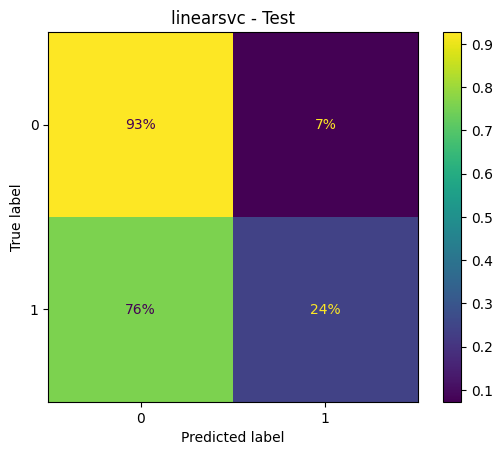

<Figure size 640x480 with 0 Axes>

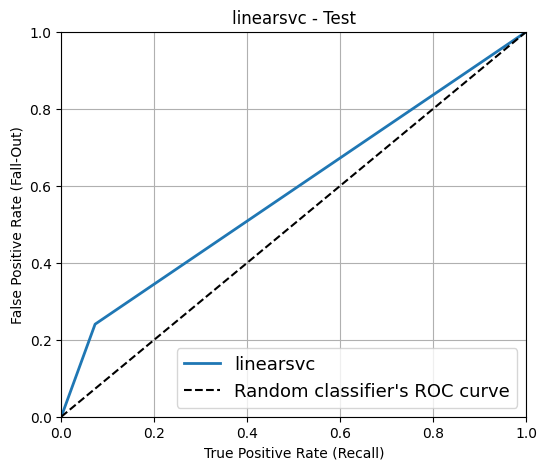

<Figure size 1000x500 with 0 Axes>

linearsvc - Test
Accuracy: 0.6736842105263158
Precision: 0.659217877094972
Recall: 0.24032586558044808
F1: 0.3522388059701492
ROC AUC: 0.5838101318367079
***************************************************************************


<Figure size 640x480 with 0 Axes>

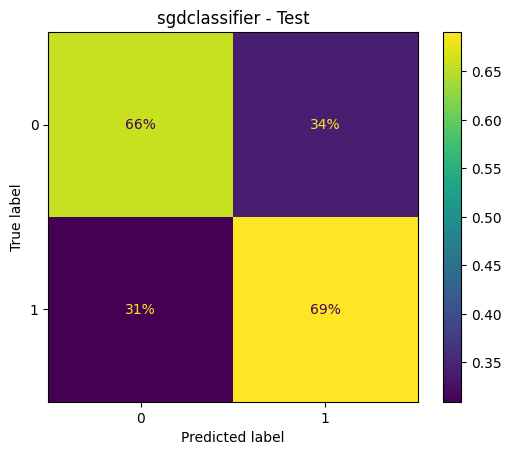

<Figure size 640x480 with 0 Axes>

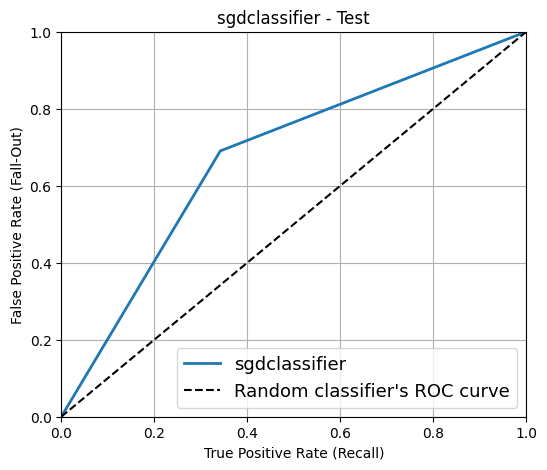

<Figure size 1000x500 with 0 Axes>

sgdclassifier - Test
Accuracy: 0.6699248120300751
Precision: 0.5415335463258786
Recall: 0.6904276985743381
F1: 0.6069829901521934
ROC AUC: 0.6741769005386589
***************************************************************************


<Figure size 640x480 with 0 Axes>

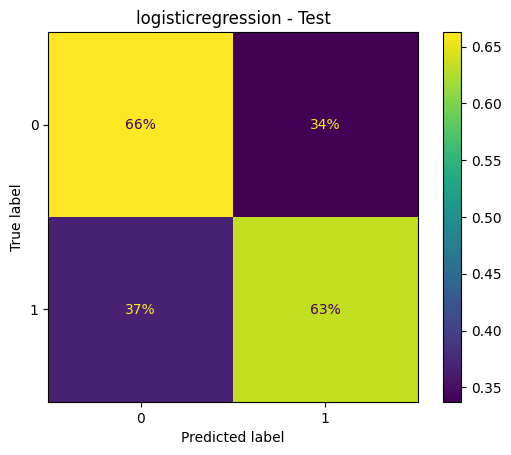

<Figure size 640x480 with 0 Axes>

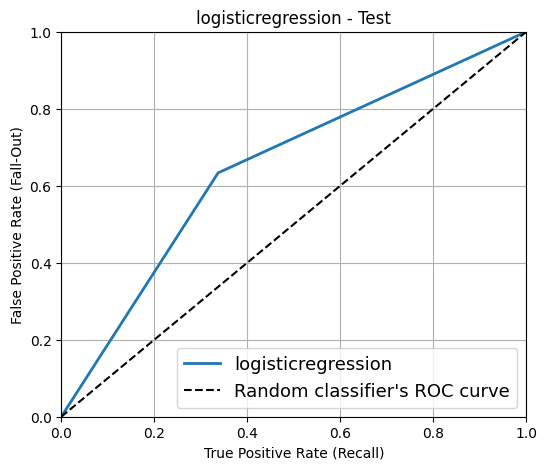

<Figure size 1000x500 with 0 Axes>

logisticregression - Test
Accuracy: 0.6518796992481203
Precision: 0.5235690235690236
Recall: 0.6334012219959266
F1: 0.5732718894009217
ROC AUC: 0.6480474524759132
***************************************************************************


<Figure size 640x480 with 0 Axes>

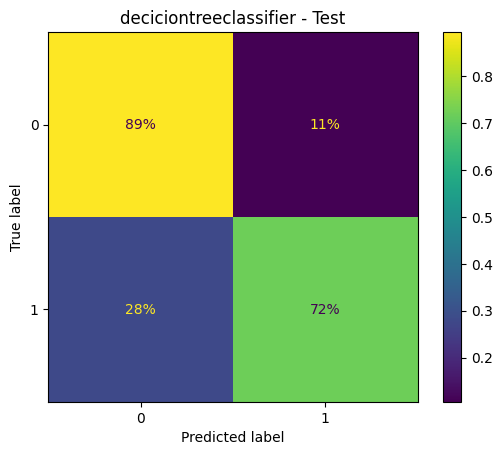

<Figure size 640x480 with 0 Axes>

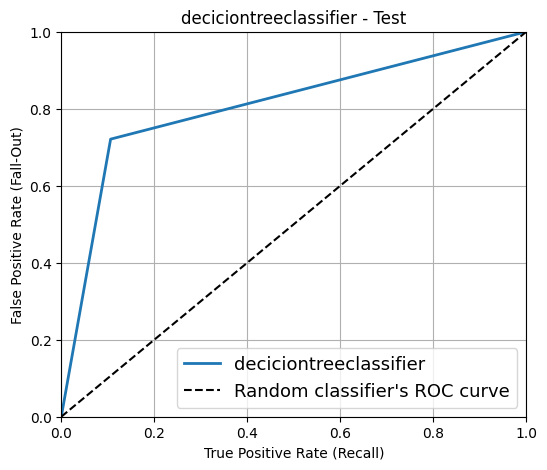

<Figure size 1000x500 with 0 Axes>

deciciontreeclassifier - Test
Accuracy: 0.8300751879699249
Precision: 0.7990970654627539
Recall: 0.7209775967413442
F1: 0.7580299785867238
ROC AUC: 0.8074494658319356
***************************************************************************


<Figure size 640x480 with 0 Axes>

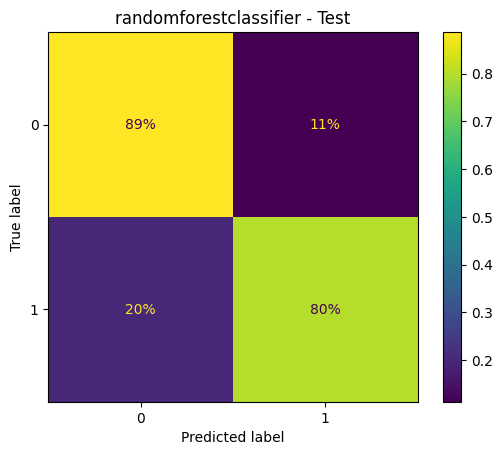

<Figure size 640x480 with 0 Axes>

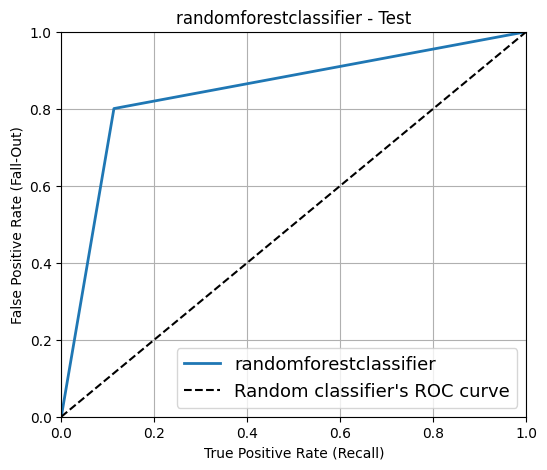

<Figure size 1000x500 with 0 Axes>

randomforestclassifier - Test
Accuracy: 0.8548872180451128
Precision: 0.805327868852459
Recall: 0.8004073319755601
F1: 0.8028600612870276
ROC AUC: 0.8435886481093534
***************************************************************************


<Figure size 640x480 with 0 Axes>

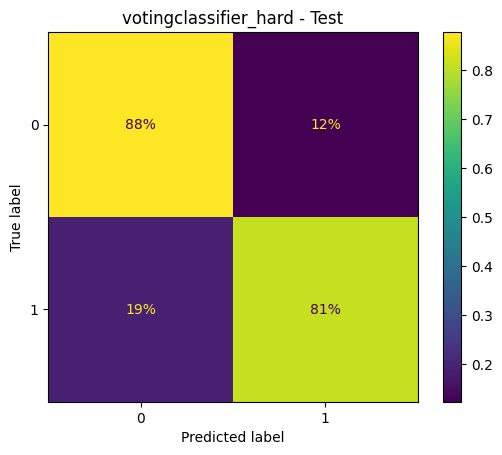

<Figure size 640x480 with 0 Axes>

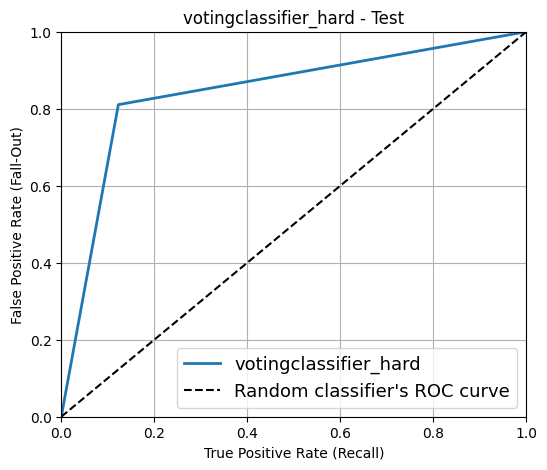

<Figure size 1000x500 with 0 Axes>

votingclassifier_hard - Test
Accuracy: 0.8526315789473684
Precision: 0.7944111776447106
Recall: 0.8105906313645621
F1: 0.8024193548387097
ROC AUC: 0.8439127173509342
***************************************************************************


<Figure size 640x480 with 0 Axes>

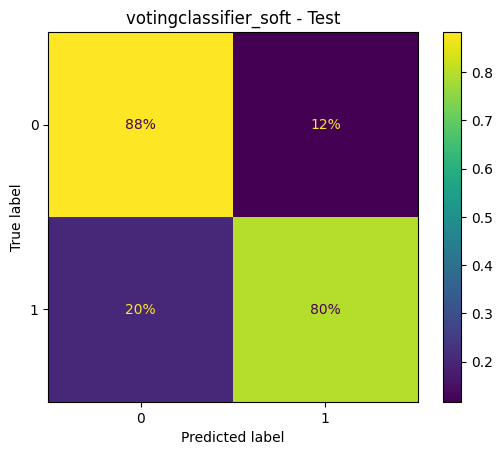

<Figure size 640x480 with 0 Axes>

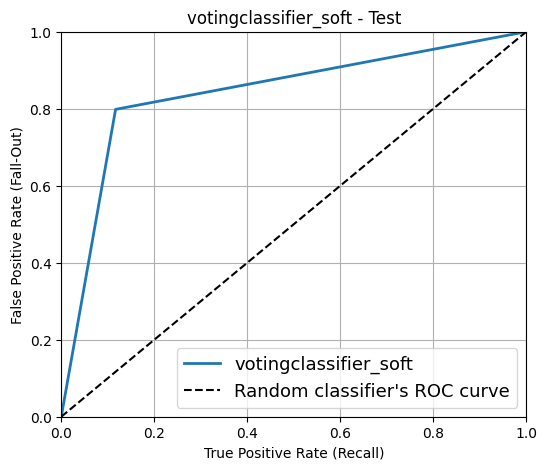

<Figure size 1000x500 with 0 Axes>

votingclassifier_soft - Test
Accuracy: 0.8518796992481203
Precision: 0.8
Recall: 0.7983706720977597
F1: 0.799184505606524
ROC AUC: 0.8407824755006081
***************************************************************************


<Figure size 640x480 with 0 Axes>

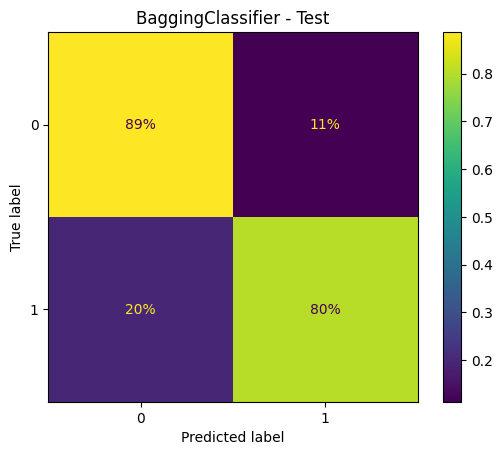

<Figure size 640x480 with 0 Axes>

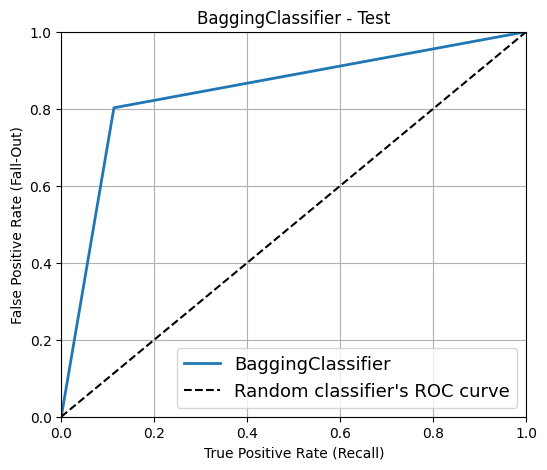

<Figure size 1000x500 with 0 Axes>

BaggingClassifier - Test
Accuracy: 0.8556390977443609
Precision: 0.8057259713701431
Recall: 0.8024439918533605
F1: 0.8040816326530612
ROC AUC: 0.8446069780482536
***************************************************************************


<Figure size 640x480 with 0 Axes>

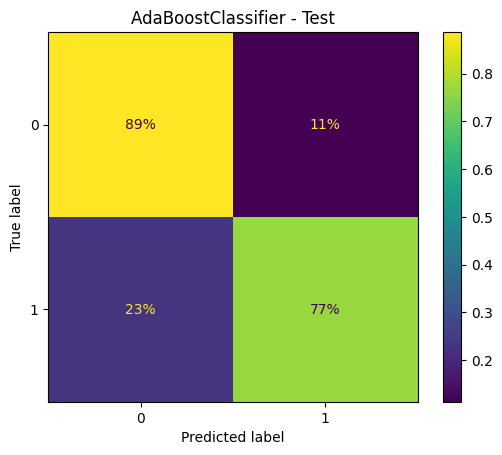

<Figure size 640x480 with 0 Axes>

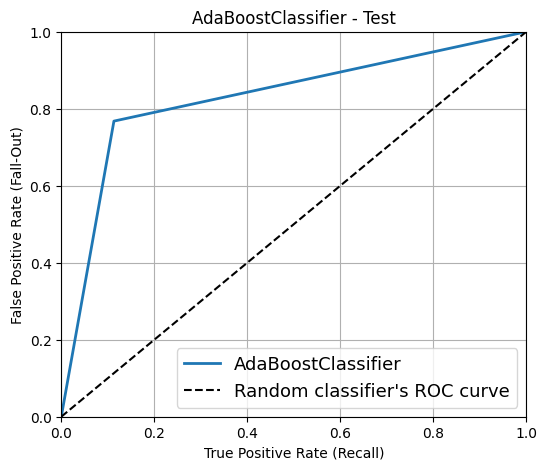

<Figure size 1000x500 with 0 Axes>

AdaBoostClassifier - Test
Accuracy: 0.8428571428571429
Precision: 0.798728813559322
Recall: 0.7678207739307535
F1: 0.7829698857736241
ROC AUC: 0.8272953690869501
***************************************************************************


<Figure size 640x480 with 0 Axes>

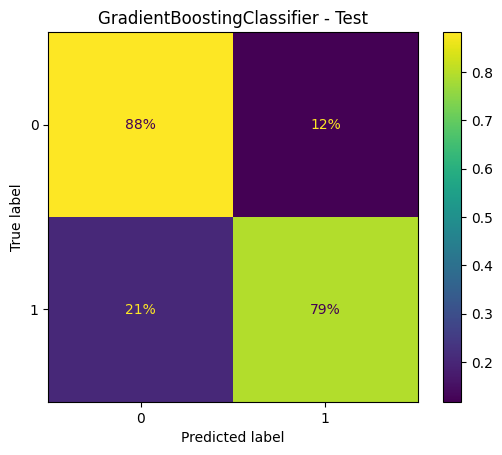

<Figure size 640x480 with 0 Axes>

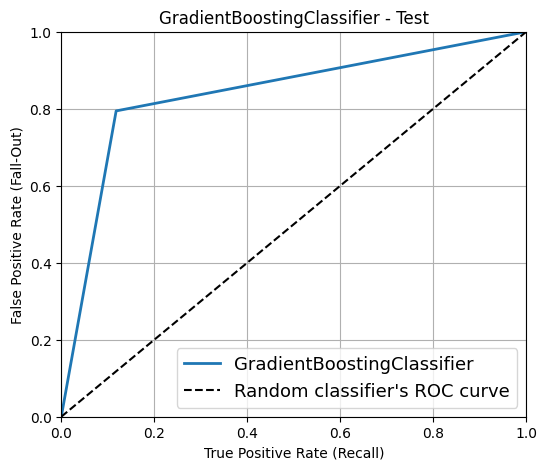

<Figure size 1000x500 with 0 Axes>

GradientBoostingClassifier - Test
Accuracy: 0.849624060150376
Precision: 0.7975460122699386
Recall: 0.7942973523421588
F1: 0.7959183673469388
ROC AUC: 0.8381498680661926
***************************************************************************


<Figure size 640x480 with 0 Axes>

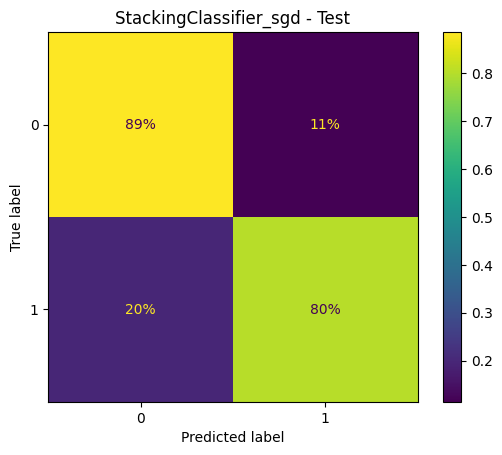

<Figure size 640x480 with 0 Axes>

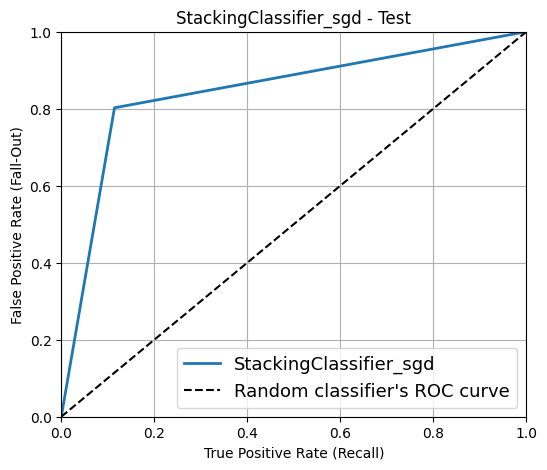

<Figure size 1000x500 with 0 Axes>

StackingClassifier_sgd - Test
Accuracy: 0.8548872180451128
Precision: 0.8040816326530612
Recall: 0.8024439918533605
F1: 0.8032619775739042
ROC AUC: 0.8440110304916386
***************************************************************************


<Figure size 640x480 with 0 Axes>

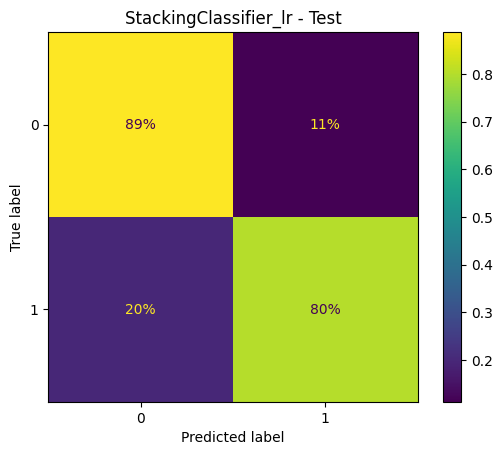

<Figure size 640x480 with 0 Axes>

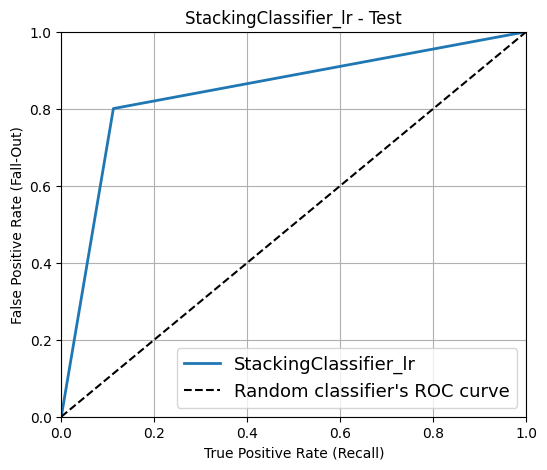

<Figure size 1000x500 with 0 Axes>

StackingClassifier_lr - Test
Accuracy: 0.8556390977443609
Precision: 0.8069815195071869
Recall: 0.8004073319755601
F1: 0.803680981595092
ROC AUC: 0.8441845956659685
***************************************************************************


<Figure size 640x480 with 0 Axes>

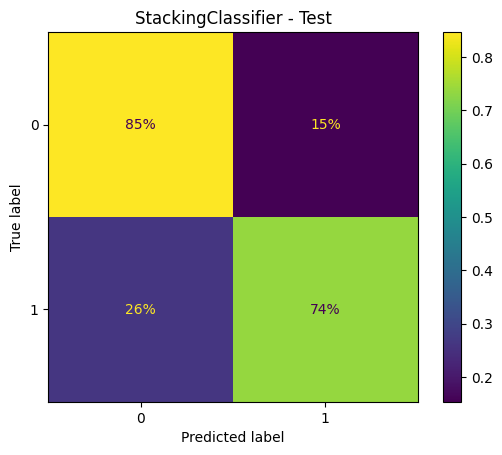

<Figure size 640x480 with 0 Axes>

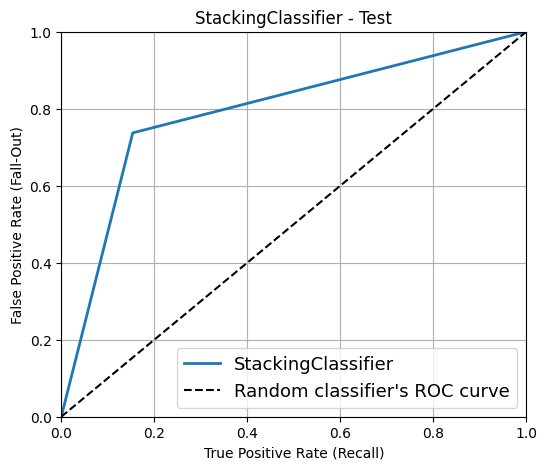

<Figure size 1000x500 with 0 Axes>

StackingClassifier - Test
Accuracy: 0.806015037593985
Precision: 0.7372708757637475
Recall: 0.7372708757637475
F1: 0.7372708757637475
ROC AUC: 0.7917582030785365
***************************************************************************


<Figure size 640x480 with 0 Axes>

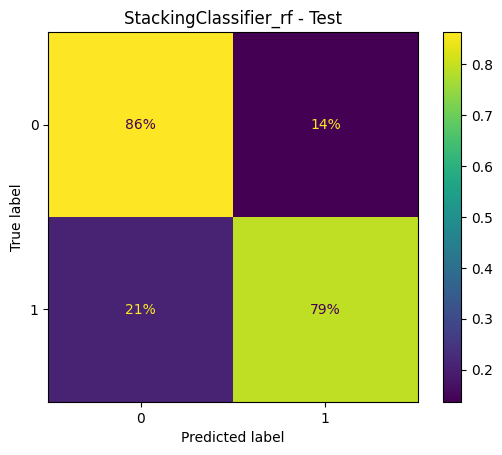

<Figure size 640x480 with 0 Axes>

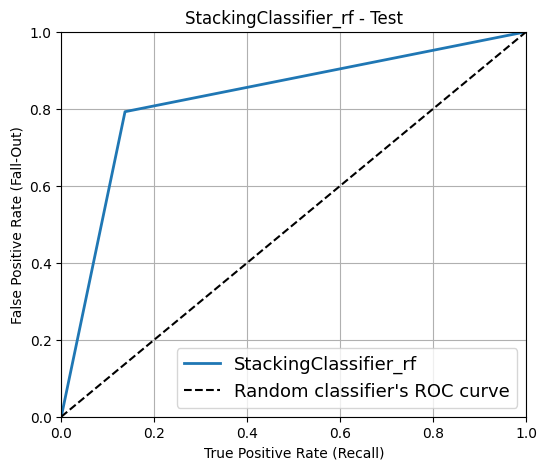

<Figure size 1000x500 with 0 Axes>

StackingClassifier_rf - Test
Accuracy: 0.8368421052631579
Precision: 0.7718253968253969
Recall: 0.7922606924643585
F1: 0.7819095477386935
ROC AUC: 0.8275963772214522
***************************************************************************


In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

for model in best_models:
    y_test_pred = model["model"].predict(X_test)

    plt.figure()
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, normalize="true", values_format='.0%')
    plt.title(f"{model['name']} - Test")
    plt.show()

    score = accuracy_score(y_test, y_test_pred) 
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)

    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    plt.figure()
    plot_roc_curve(fpr, tpr, label=model["name"])
    plt.show()
    
    print(f"{model['name']} - Test")
    print(f"Accuracy: {score.mean()}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print(75 * "*")

    model_comparison_test.append({
        "Name": model["name"],
        "accuracy": score,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    })

In [96]:
model_comparison_test = pd.DataFrame(model_comparison_test)
model_comparison_test

,Name,accuracy,precision,recall,f1,roc_auc
0,linearsvc,0.673684,0.659218,0.240326,0.352239,0.583810
1,sgdclassifier,0.669925,0.541534,0.690428,0.606983,0.674177
2,logisticregression,0.651880,0.523569,0.633401,0.573272,0.648047
3,deciciontreeclassifier,0.830075,0.799097,0.720978,0.758030,0.807449
4,randomforestclassifier,0.854887,0.805328,0.800407,0.802860,0.843589
5,votingclassifier_hard,0.852632,0.794411,0.810591,0.802419,0.843913
6,votingclassifier_soft,0.851880,0.800000,0.798371,0.799185,0.840782
7,BaggingClassifier,0.855639,0.805726,0.802444,0.804082,0.844607
8,AdaBoostClassifier,0.842857,0.798729,0.767821,0.782970,0.827295
9,GradientBoostingClassifier,0.849624,0.797546,0.794297,0.795918,0.838150


In [97]:
model_comparison_test.sort_values(by="recall", ascending=False)

,Name,accuracy,precision,recall,f1,roc_auc
5,votingclassifier_hard,0.852632,0.794411,0.810591,0.802419,0.843913
7,BaggingClassifier,0.855639,0.805726,0.802444,0.804082,0.844607
10,StackingClassifier_sgd,0.854887,0.804082,0.802444,0.803262,0.844011
4,randomforestclassifier,0.854887,0.805328,0.800407,0.802860,0.843589
11,StackingClassifier_lr,0.855639,0.806982,0.800407,0.803681,0.844185
6,votingclassifier_soft,0.851880,0.800000,0.798371,0.799185,0.840782
9,GradientBoostingClassifier,0.849624,0.797546,0.794297,0.795918,0.838150
13,StackingClassifier_rf,0.836842,0.771825,0.792261,0.781910,0.827596
8,AdaBoostClassifier,0.842857,0.798729,0.767821,0.782970,0.827295
12,StackingClassifier,0.806015,0.737271,0.737271,0.737271,0.791758


In [98]:
import pickle as pkl

voting_hard = best_models[5]
filename = f'../models/epic8/{voting_hard["name"]}.pkl'
with open(filename, 'wb') as file:
    pkl.dump(voting_hard["model"], file)